In [1]:
%load_ext autoreload
%autoreload 2

## Imports

In [2]:
import pandas as pd
from plotnine import (
    ggplot, aes, geom_line, geom_point, facet_grid, stat_summary,
    theme, element_text, theme_bw, geom_boxplot, geom_bar, ylim,
    geom_tile, geom_text, geom_vline, coord_cartesian, coord_trans
)
from plotnine.scales import scale_y_log10, scale_x_log10, scale_x_discrete, scale_y_reverse, scale_fill_cmap, scale_y_continuous
import os

In [3]:
import torch
import numpy as np
from tqdm import tqdm
import math
import json

DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

## Useful definitions

In [41]:
def plot_fits(
    df: pd.DataFrame,
    k: int,
    layers: int,
    all_models: dict,
    x_line: float | None = None,
):
    est_nlls = []
    subset = df[(df['k'] == k) & (df['layers'] == layers)]
    for hmm in subset['hmm'].unique():
        hmm_set = subset[subset['hmm'] == hmm]
        max_shots = hmm_set['shots'].max()
        for law in ['original', 'sampling', 'scoring', 'power', 'bounded', 'logistic']:
            if law in ['original', 'sampling', 'scoring']:
                model = all_models[(law, k, layers)]
            else:
                model = all_models[(law, k, layers, hmm)]
            preds = model.estimate_nll(max_shots, hmm)
            for i, pred in enumerate(preds[1:]):
                est_nlls.append({
                    'shots': i,
                    'nll': pred.item(),
                    'prob': (-pred).exp().item(),
                    'law': law,
                    'hmm': hmm,
                })
    
    # plot
    est_nlls_df = pd.DataFrame(est_nlls)
    mini = subset['nll'].min()
    maxi = subset['nll'].max()
    mini, maxi = mini - 0.1 * (maxi - mini), maxi + 0.1 * (maxi - mini)
    # print(est_nlls_df)
    print(subset['nll'].min(), subset['nll'].max())
    plot = (
        ggplot() + geom_line(subset, aes(x='shots', y='nll')) +
        geom_line(est_nlls_df, aes(x='shots', y='nll', color='law'), size=1) +
        facet_grid("~hmm", labeller="label_both") +
        theme_bw() + 
        theme(axis_text_x=element_text(rotation=90)) +
        scale_x_log10() + scale_y_log10(limits=(mini, maxi), expand=(0, 0))
        # coord_trans(ylim=(subset['nll'].min(), subset['nll'].max()))
    )
    if x_line is not None:
        x_line = subset['shots'].max() * x_line
        plot += geom_vline(xintercept=x_line, color='red', linetype='dashed')
    print(plot)

    plot = (
        ggplot() + geom_line(subset, aes(x='shots', y='prob')) +
        geom_line(est_nlls_df, aes(x='shots', y='prob', color='law'), size=1) +
        facet_grid("~hmm", labeller="label_both") +
        theme_bw() + 
        theme(axis_text_x=element_text(rotation=90)) +
        scale_x_log10() + scale_y_continuous(limits=(0, 1), expand=(0, 0))
        # coord_trans(ylim=(subset['nll'].min(), subset['nll'].max()))
    )
    if x_line is not None:
        plot += geom_vline(xintercept=x_line, color='red', linetype='dashed')
    print(plot)

In [11]:
def make_df(perc, data):
    res = pd.DataFrame(data)
    res["perc"] = perc
    return res

## Load data

In [5]:
for layers in [1, 2, 3, 4, 8, 12, 16]:
    doc = f"logs/{layers}-1,1,1,1,1-1,0,0,0,0/trainer_state.json"
    with open(doc, "r") as f:
        data = json.load(f)
    train_loss = [x for x in data["log_history"] if "loss" in x][-1]["loss"]
    eval_loss = [x for x in data["log_history"] if "eval_loss" in x][-1]["eval_loss"]
    print(f"\\texttt{{gpt}}$_{layers}$ & ${train_loss:.3f}$ & ${eval_loss:.3f}$ \\\\")

FileNotFoundError: [Errno 2] No such file or directory: 'logs/1-1,1,1,1,1-1,0,0,0,0/trainer_state.json'

In [6]:
datas = []
for layers in [1, 2, 3, 4, 8, 12, 16]:
    data = pd.read_csv(f"logs/{layers}-1,1,1,1,1-1,0,0,0,0/in_context_probs.csv")
    data['shots'] = data['shots'] + 1
    data['layers'] = layers
    datas.append(data)
data = pd.concat(datas)

filter = (data['sft_amount'] == -1)
for sft_amount in data['sft_amount'].unique():
    maxi = data[data['sft_amount'] == sft_amount]['sft'].max()
    filter |= ((data['sft'] == maxi) & (data['sft_amount'] == sft_amount)) 
data = data[filter]

In [7]:
pretrain_data = data[data["sft_amount"] == 0].copy()
pretrain_data["tokens"] = pretrain_data["shots"] * (pretrain_data["k"] + 1)

## ICL plots (no fits)

In [ ]:
plot = (
    ggplot(pretrain_data, aes(x="tokens", y="acc", color="k", group="k")) +
    stat_summary(geom="line") + facet_grid("~layers", labeller="label_both") +
    theme_bw() + theme(axis_text_x=element_text(rotation=90))
)
print(plot)
plot.save('paper/icl_curve.pdf', width=7, height=2.5)

In [ ]:
plot = (
    ggplot(pretrain_data, aes(x="shots", y="acc", color="k", group="k")) +
    stat_summary(geom="line") + facet_grid("~layers", labeller="label_both") +
    theme_bw() + theme(axis_text_x=element_text(rotation=90))
)
print(plot)

In [ ]:
plot = (
    ggplot(pretrain_data, aes(x="tokens", y="acc", color="k", group="k")) +
    geom_line() + facet_grid("layers~hmm", labeller="label_both") +
    theme_bw() + theme(axis_text_x=element_text(rotation=90))
)
print(plot)
plot.save('paper/icl_curve_hmm.pdf', width=7, height=7)

## Bayesian law fits

In [8]:
from analyse import compute_all_fits, power_law_mapping, bayesian_law_mapping

all_params = {}
all_models = {}

In [9]:
pretrain_data_mean = pretrain_data.groupby(["shots", "k", "hmm", "sft", "sft_amount", "layers", "tokens"]).mean().reset_index()
pretrain_data_mean["nll_avg"] = pretrain_data_mean["nll"]
pretrain_data_mean["nll"] = pretrain_data_mean["prob"].map(lambda x: -math.log(x))
pretrain_data_mean

,shots,k,hmm,sft,sft_amount,layers,tokens,Unnamed: 0,prob,acc,nll,nll_avg
0,1,3,0,0,0,1,4,0.0,0.241505,0.467593,1.420865,1.687721
1,1,3,0,0,0,2,4,0.0,0.200616,0.407407,1.606362,1.852371
2,1,3,0,0,0,3,4,0.0,0.182365,0.282407,1.701747,2.035992
3,1,3,0,0,0,4,4,0.0,0.226609,0.370370,1.484531,1.772636
4,1,3,0,0,0,8,4,0.0,0.231270,0.393519,1.464169,1.730885
...,...,...,...,...,...,...,...,...,...,...,...,...
22115,256,3,4,0,0,3,1024,135837.0,0.248565,0.395349,1.392052,2.133031
22116,256,3,4,0,0,4,1024,135837.0,0.319879,0.517442,1.139811,1.734641
22117,256,3,4,0,0,8,1024,135837.0,0.364657,0.575581,1.008797,1.485995
22118,256,3,4,0,0,12,1024,135837.0,0.355050,0.587209,1.035497,1.622746


### Extrapolation

With 5%, 10%, 20%, and 50% of the data.

In [10]:
for perc in [0.05, 0.1, 0.2, 0.5]:
    all_params[perc] = []
    all_models[perc] = {}
    
    for i in range(1):
        for k in pretrain_data_mean["k"].unique():
            for layers in tqdm(pretrain_data_mean["layers"].unique()):
                subset = pretrain_data_mean[(pretrain_data_mean["k"] == k) & (pretrain_data_mean["layers"] == layers)]
                some_params, some_models = compute_all_fits(
                    subset=subset, max_shots=perc, quiet=True, patience=100, epochs=100,
                    lr=5e-2, num_hmms=5, i=i, metadata={"layers": layers, "k": k},
                    mode="lbfgs", loss_mode="mse_prob"
                )
                all_params[perc].extend(some_params)
                for key in some_models:
                    if isinstance(key, tuple): # (law, hmm)
                        all_models[perc][(key[0], k, layers, key[1])] = some_models[key]
                    else: # just law
                        all_models[perc][(key, k, layers)] = some_models[key]

    df = pd.DataFrame(all_params[perc])
    print(perc)
    print(df.groupby(["layers", "law"])["nrmse_prob"].mean().unstack().to_latex(float_format="{:.4f}".format))
    nans_by_law = df["nrmse_prob"].isna().groupby(df["law"]).sum()
    print(nans_by_law)
    # print("\n")
    # print(df.groupby(["layers", "law"])["log_nrmse"].mean().unstack().to_latex(float_format="{:.3f}".format))
    print("\n\n")

  0%|          | 0/7 [00:06<?, ?it/s]


KeyboardInterrupt: 

In [22]:
df = pd.concat(map(lambda x: make_df(x, all_params[x]), all_params.keys()))
df

,hmm,rmse,nrmse,log_rmse,log_nrmse,rmse_prob,nrmse_prob,law,priors,P,...,layers,k,gammas,betas,C,alpha,n_c,L,x_0,perc
0,0,0.223595,0.161078,0.127721,0.701606,0.038711,0.152249,bayesian_original,0.223654,"[0.15819478034973145, 0.2597258388996124, 0.25...",...,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.05
1,0,0.224576,0.161784,0.128375,0.704682,0.038923,0.153082,bayesian_sampling,0.236719,NaN,...,1,3,0.261031,0.217106,NaN,NaN,NaN,NaN,NaN,0.05
2,0,0.223462,0.160982,0.127635,0.701187,0.038684,0.152142,bayesian_scoring,0.284448,NaN,...,1,3,0.259491,0.226943,NaN,NaN,NaN,NaN,NaN,0.05
3,0,0.227520,0.163905,0.130497,0.713919,0.039649,0.155937,power,NaN,NaN,...,1,3,NaN,NaN,0.108961,0.693601,NaN,NaN,NaN,0.05
4,0,0.223701,0.161154,0.127789,0.701936,0.038733,0.152334,bounded,NaN,NaN,...,1,3,NaN,NaN,0.155325,14.998974,3.314190,NaN,NaN,0.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,4,0.020077,0.027906,0.027804,-0.060910,0.009750,0.020016,bayesian_sampling,0.001482,NaN,...,16,10,0.489814,0.381785,NaN,NaN,NaN,NaN,NaN,0.50
836,4,0.019898,0.027657,0.027565,-0.060367,0.009665,0.019842,bayesian_scoring,0.010308,NaN,...,16,10,0.489630,0.489458,NaN,NaN,NaN,NaN,NaN,0.50
837,4,0.027442,0.038143,0.038151,-0.083255,0.013364,0.027436,power,NaN,NaN,...,16,10,NaN,NaN,0.566669,0.020834,NaN,NaN,NaN,0.50
838,4,0.028491,0.039601,0.039654,-0.086437,0.013886,0.028508,bounded,NaN,NaN,...,16,10,NaN,NaN,0.200053,0.084159,0.791132,NaN,NaN,0.50


In [23]:
# Assuming 'df' is your original DataFrame
average_nrmse = df[df["perc"] < 1.0].groupby(['perc', 'layers', 'law'])['nrmse_prob'].mean().unstack()

# Function to bold the minimum value in each row
def bold_min(row):
    min_val = row.min()
    # Apply bold formatting to the minimum value
    return row.apply(lambda x: f'\\textbf{{{x:.4f}}}' if x == min_val else f'{x:.4f}')

# Apply the function to each row
average_nrmse_bold = average_nrmse.apply(bold_min, axis=1)

# Convert to LaTeX, ensuring that LaTeX commands are not escaped
latex_table = average_nrmse_bold.to_latex(escape=False)

# Replace underscores with escaped underscores for LaTeX compatibility
latex_table = latex_table.replace('_', '\\_')

# Print or save the LaTeX table
print(latex_table)

\begin{tabular}{llllllll}
\toprule
 & law & bayesian\_original & bayesian\_sampling & bayesian\_scoring & bounded & logistic & power \\
perc & layers &  &  &  &  &  &  \\
\midrule
\multirow[t]{7}{*}{0.050000} & 1 & 0.1608 & 0.3167 & 0.4478 & 0.2434 & 0.1695 & \textbf{0.1569} \\
 & 2 & 0.2329 & 0.1402 & 0.2883 & 0.2350 & 0.2586 & \textbf{0.1366} \\
 & 3 & 0.0555 & 0.3938 & \textbf{0.0454} & 0.1118 & 0.0972 & 0.1233 \\
 & 4 & 0.1406 & 0.2432 & 0.0947 & 0.3053 & 0.1494 & \textbf{0.0835} \\
 & 8 & 0.1225 & 0.2711 & 0.1117 & 0.0902 & 0.0747 & \textbf{0.0514} \\
 & 12 & \textbf{0.0442} & 0.0901 & 0.2387 & 0.1008 & 0.0739 & 0.0512 \\
 & 16 & 0.1306 & 0.2068 & 0.1542 & 0.1280 & 0.0740 & \textbf{0.0538} \\
\cline{1-8}
\multirow[t]{7}{*}{0.100000} & 1 & 0.3835 & 0.1516 & \textbf{0.1504} & 0.1726 & 0.1569 & 0.1556 \\
 & 2 & 0.3026 & 0.1271 & 0.1107 & 0.1108 & 0.1126 & \textbf{0.1106} \\
 & 3 & 0.1079 & 0.0507 & \textbf{0.0466} & 0.0553 & 0.0583 & 0.0792 \\
 & 4 & 0.1562 & 0.0777 & 0.0754 & 0.0996

    perc                law  nrmse_prob      law_type
0   0.05  bayesian_original    0.098710      bayesian
1   0.05  bayesian_sampling    0.241009      bayesian
2   0.05   bayesian_scoring    0.128944      bayesian
3   0.05            bounded    0.147214  non-bayesian
4   0.05           logistic    0.093847  non-bayesian
5   0.05              power    0.072652  non-bayesian
6   0.10  bayesian_original    0.121133      bayesian
7   0.10  bayesian_sampling    0.048616      bayesian
8   0.10   bayesian_scoring    0.048913      bayesian
9   0.10            bounded    0.056180  non-bayesian
10  0.10           logistic    0.054558  non-bayesian
11  0.10              power    0.055915  non-bayesian
12  0.20  bayesian_original    0.048286      bayesian
13  0.20  bayesian_sampling    0.038049      bayesian
14  0.20   bayesian_scoring    0.037764      bayesian
15  0.20            bounded    0.041962  non-bayesian
16  0.20           logistic    0.041369  non-bayesian
17  0.20              power 

/var/folders/ks/tsqyvj_n5bv55g97m0fc7tb40000gn/T/ipykernel_64473/4132154616.py:9: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


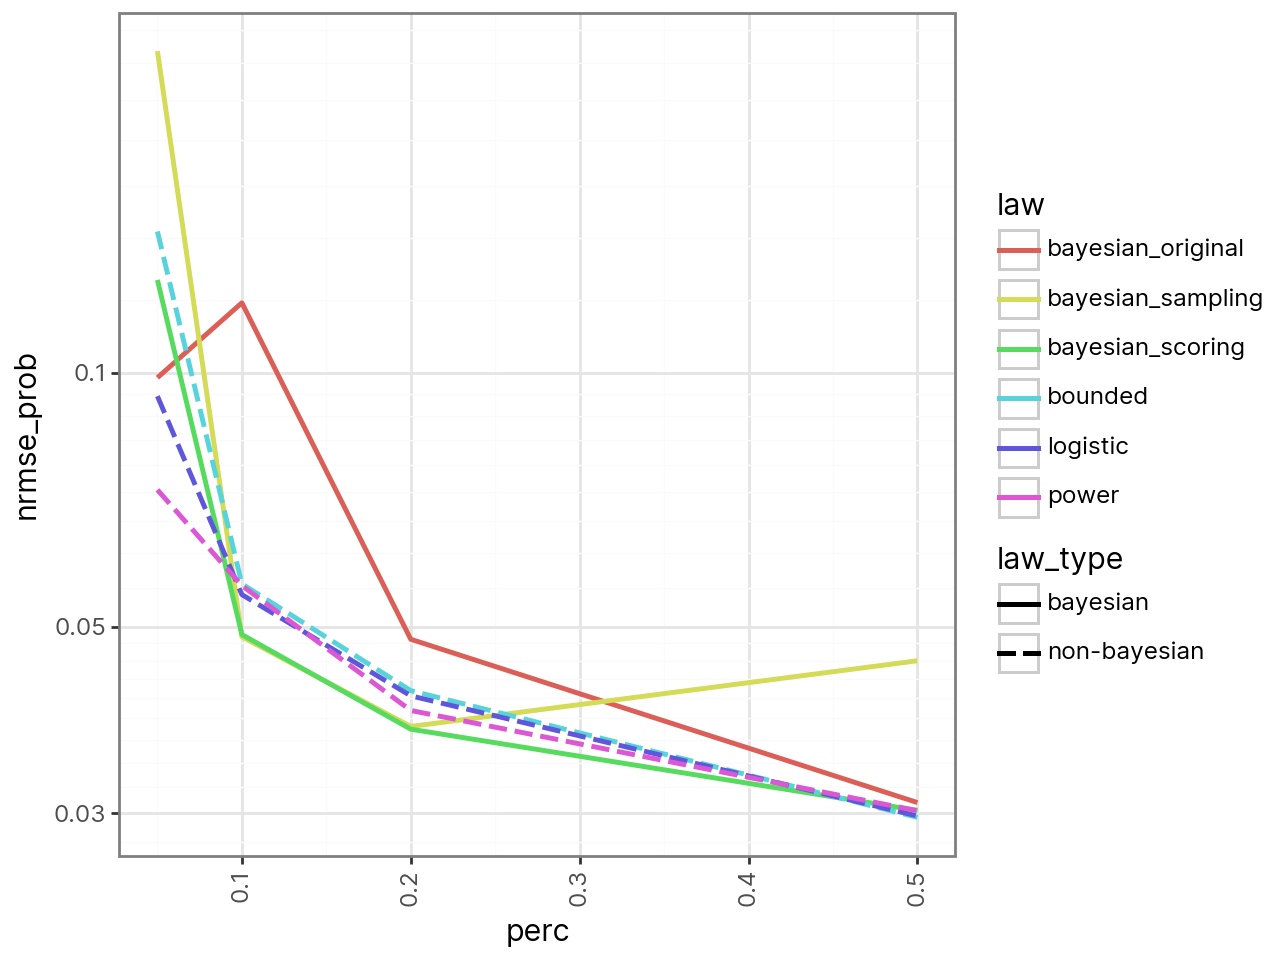

In [24]:
extrap = df[(df["layers"] > 2) & (df["perc"] < 1)].groupby(['perc', 'law'])['nrmse_prob'].mean().reset_index()
# extrap["perc"] = extrap["perc"].map(lambda x: f"{x:.2f}")
extrap["law_type"] = extrap["law"].map(lambda x: "bayesian" if (x.split("_")[0] == "bayesian") else "non-bayesian")
print(extrap)
plot = (
    ggplot(extrap, aes(x="perc", y="nrmse_prob", color="law", linetype="law_type")) + geom_line(size=1) +
    scale_y_log10() + theme_bw() + theme(axis_text_x=element_text(rotation=90), text=element_text(family="Inter"))
)
print(plot)

In [25]:
from scipy import stats

extrap = df[(df["layers"] > 2) & (df["perc"] == 0.1)].groupby(['perc', 'hmm', 'layers', 'k', 'law'])['nrmse_prob'].mean().unstack().reset_index()
extrap

print("Extrapolation test")
for law in df["law"].unique():
    for law2 in df["law"].unique():
        if law == law2:
            continue
        # print(law, law2)
        ttest = stats.ttest_rel(
            extrap[law],
            extrap[law2]
        )
        print(f"{'✅' if ttest.pvalue < 0.05 else '❌'} {'>' if ttest.statistic > 0 else '<'} {law:>20} vs {law2:<20}: {ttest.statistic:>8.4f}, {ttest.pvalue:>8.4f}")


Extrapolation test
✅ >    bayesian_original vs bayesian_sampling   :   3.4751,   0.0008
✅ >    bayesian_original vs bayesian_scoring    :   3.1812,   0.0020
✅ >    bayesian_original vs power               :   3.0383,   0.0030
✅ >    bayesian_original vs bounded             :   3.1138,   0.0024
✅ >    bayesian_original vs logistic            :   3.0186,   0.0032
✅ <    bayesian_sampling vs bayesian_original   :  -3.4751,   0.0008
❌ <    bayesian_sampling vs bayesian_scoring    :  -0.0436,   0.9653
❌ <    bayesian_sampling vs power               :  -1.4507,   0.1500
❌ <    bayesian_sampling vs bounded             :  -1.6556,   0.1010
❌ <    bayesian_sampling vs logistic            :  -0.9697,   0.3345
✅ <     bayesian_scoring vs bayesian_original   :  -3.1812,   0.0020
❌ >     bayesian_scoring vs bayesian_sampling   :   0.0436,   0.9653
❌ <     bayesian_scoring vs power               :  -1.0665,   0.2888
❌ <     bayesian_scoring vs bounded             :  -0.8305,   0.4083
❌ <     bayesia

0.552616234251898 1.1880743044815445


/var/folders/ks/tsqyvj_n5bv55g97m0fc7tb40000gn/T/ipykernel_64473/3162278965.py:47: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


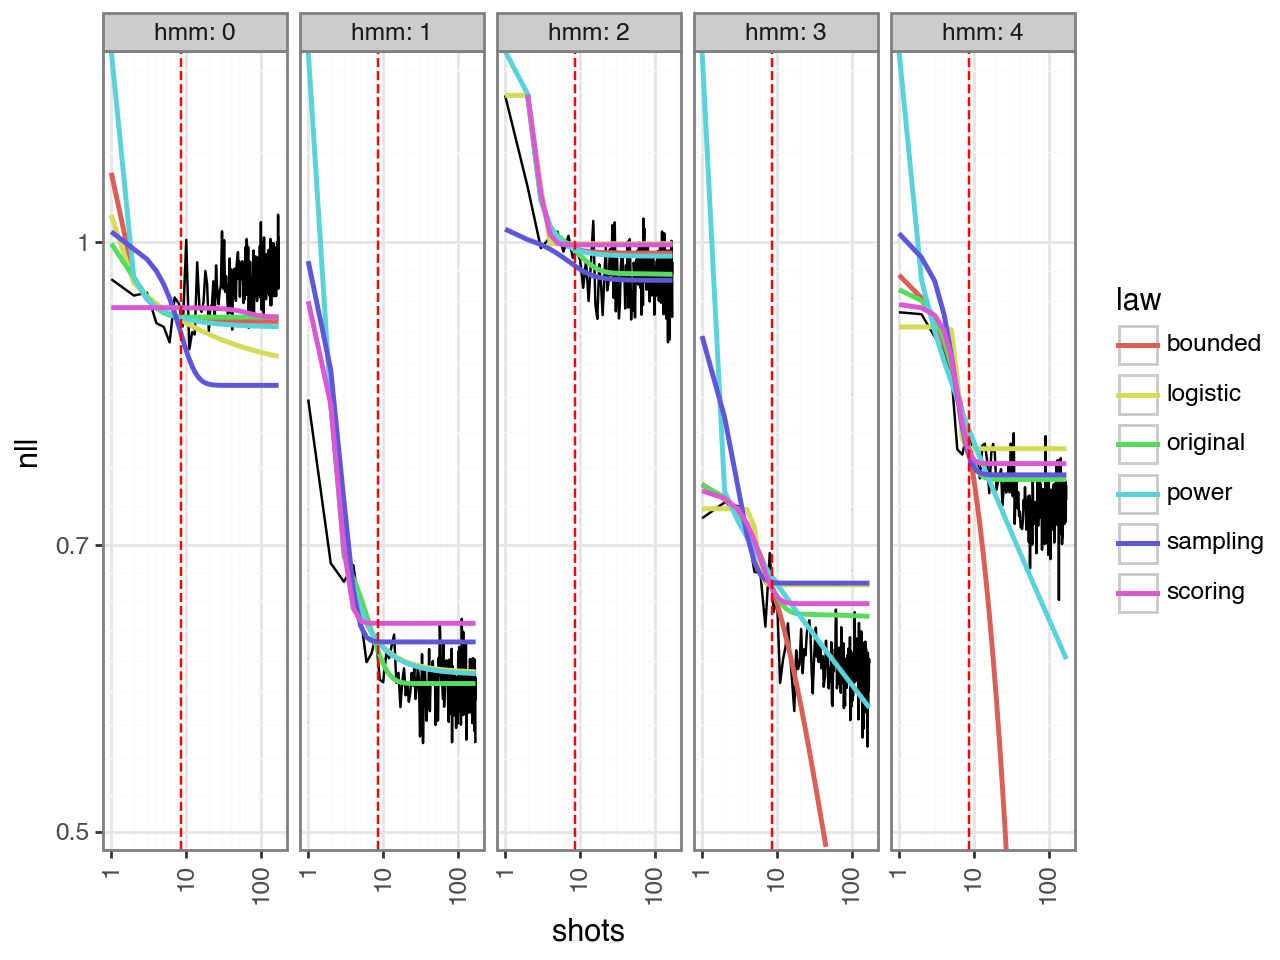

/var/folders/ks/tsqyvj_n5bv55g97m0fc7tb40000gn/T/ipykernel_64473/3162278965.py:60: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


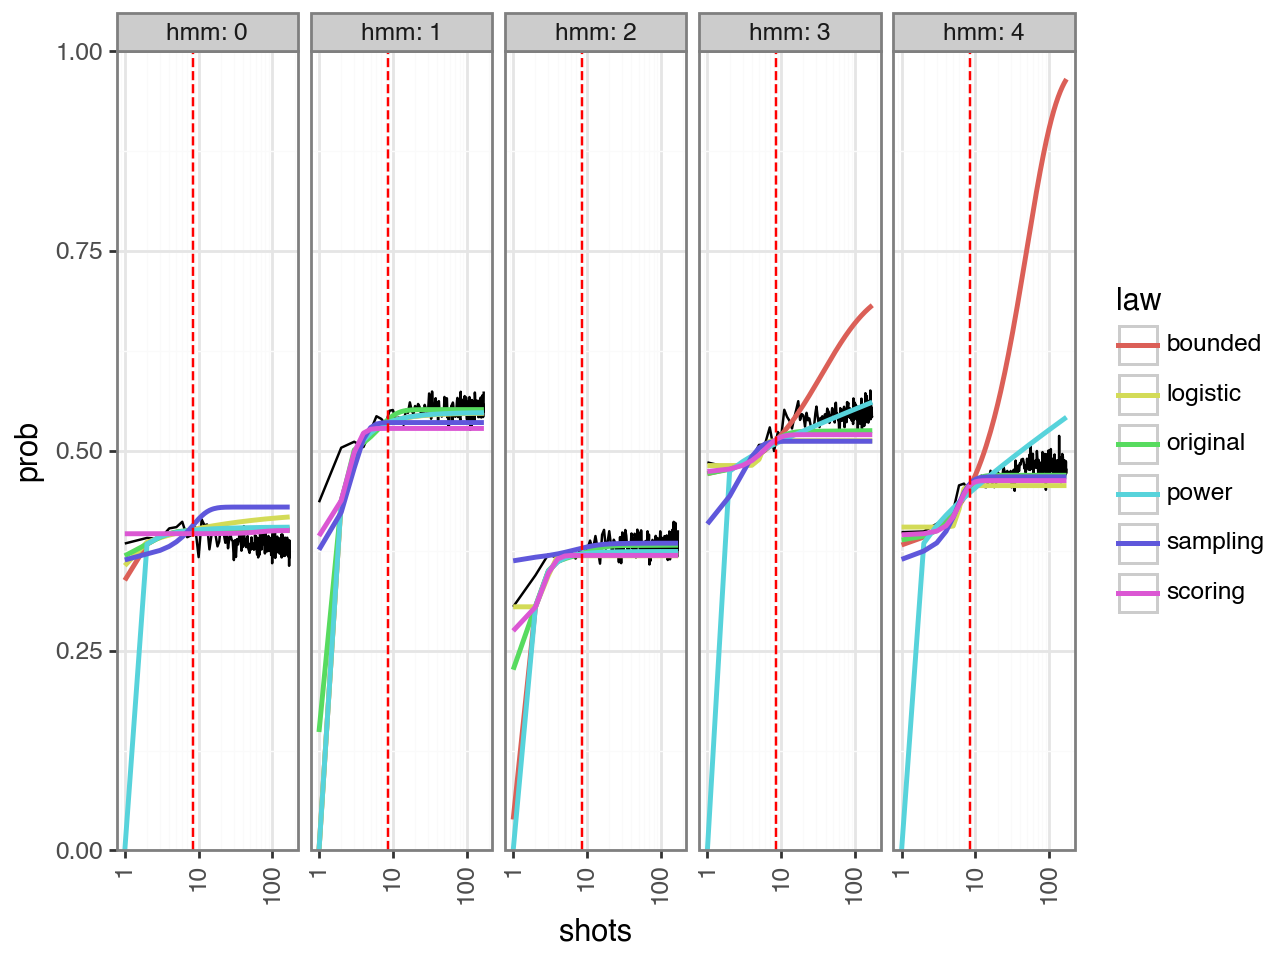

In [26]:
plot_fits(pretrain_data_mean, 5, 16, all_models[0.05], x_line=0.05)

### Interpolation

All of the data!

In [ ]:
perc = 1.0
all_params[perc] = []
for i in range(1):
    all_models[(perc, i)] = {}
    for k in pretrain_data_mean["k"].unique():
        for layers in tqdm(pretrain_data_mean["layers"].unique()):
            subset = pretrain_data_mean[(pretrain_data_mean["k"] == k) & (pretrain_data_mean["layers"] == layers)]
            some_params, some_models = compute_all_fits(
                subset=subset, max_shots=perc, quiet=True, patience=100, epochs=100,
                lr=5e-2, num_hmms=5, i=i, metadata={"layers": layers, "k": k},
                mode="lbfgs", loss_mode="mse_prob"
            )
            for d in some_params:
                d["layers"] = layers
                d["k"] = k
            all_params[perc].extend(some_params)
            for key in some_models:
                if isinstance(key, tuple): # (law, hmm)
                    all_models[(perc, i)][(key[0], k, layers, key[1])] = some_models[key]
                else: # just law
                    all_models[(perc, i)][(key, k, layers)] = some_models[key]

In [ ]:
df = pd.DataFrame(all_params[perc])
print(f"Dropped {len(df[df['nrmse'].isna() == True])} of {len(df)} observation(s)")
df = df[df["nrmse"].isna() == False]
print(perc)
print(df.groupby(["layers", "law"])["nrmse"].mean().unstack().to_latex(float_format="{:.4f}".format))
nans_by_law = df["nrmse"].isna().groupby(df["law"]).sum()
print(nans_by_law)

In [ ]:
plot_fits(pretrain_data_mean, 5, 16, all_models[(1.0, 0)])

In [ ]:
from scipy import stats

df = pd.concat(map(lambda x: make_df(x, all_params[x]), all_params.keys()))
extrap = df[(df["layers"] > 2) & (df["perc"] == 1.0)].groupby(['perc', 'hmm', 'layers', 'k', 'law'])['nrmse_prob'].mean().unstack().reset_index()
extrap

print("Interpolation test")
for law in df["law"].unique():
    for law2 in df["law"].unique():
        if law == law2:
            continue
        # print(law, law2)
        ttest = stats.ttest_rel(
            extrap[law],
            extrap[law2]
        )
        print(f"{'✅' if ttest.pvalue < 0.05 else '❌'} {'>' if ttest.statistic > 0 else '<'} {law:>20} vs {law2:<20}: {ttest.statistic:>8.4f}, {ttest.pvalue:>8.4f}")


### Plots

In [30]:
perc = 1.0
params_df = pd.DataFrame(all_params[perc])
params_df.to_csv('paper/params.csv', index=False)
params_df['hmm'] = pd.Categorical(params_df['hmm'], categories=params_df['hmm'].unique(), ordered=False)
params_df['k'] = params_df['k'].astype(int)
params_df['law'] = params_df['law'].map({
    "bayesian_original": "Bayesian (O.)",
    "bayesian_sampling": "Bayesian (Sa.)",
    "bayesian_scoring": "Bayesian (Sc.)",
    "bayesian_old": "Bayesian (Old)",
    "power": "Power",
    "bounded": "Bounded",
    "logistic": "Logistic",
})

In [ ]:
params_df

In [ ]:
params_df["law_type"] = params_df["law"].map(lambda x: "bayesian" if (x.split(" ")[0] == "Bayesian") else "non-bayesian")
plot = (
    ggplot(params_df[(params_df["layers"] > 2) & ~(params_df["law"].str.endswith("l"))], aes(x="layers", y="nrmse_prob", group="law", color="law")) +
    stat_summary(aes(linetype="law_type"), geom="line", size=1) +
    stat_summary() +
    facet_grid("~k", labeller="label_both") +
    theme_bw() + theme(axis_text_x=element_text(rotation=90), text=element_text(family="Inter")) + scale_y_log10()
)
print(plot)
plot.save('paper/law_comparison.pdf', width=6, height=3)

In [ ]:
print(params_df[(params_df["layers"] > 2) & ~(params_df["law"].str.endswith("l"))].groupby("law")["nrmse_prob"].mean().to_latex(float_format="{:.4f}".format))
print(params_df[(params_df["layers"] > 2) & ~(params_df["law"].str.endswith("l"))].groupby("law")["nrmse_prob"].std().to_latex(float_format="{:.4f}".format))

In [ ]:
params_df_50 = pd.DataFrame(all_params[0.1])
print(params_df_50[(params_df_50["layers"] > 2) & ~(params_df_50["law"].str.endswith("(log)"))].groupby("law")["nrmse"].mean().to_latex(float_format="{:.4f}".format))
print(params_df_50[(params_df_50["layers"] > 2) & ~(params_df_50["law"].str.endswith("(log)"))].groupby("law")["nrmse"].std().to_latex(float_format="{:.4f}".format))

In [ ]:
laws_list = sorted(list(params_df["law"].unique()))
print(laws_list)
for layers in params_df["layers"].unique():
    print(layers, end='')
    for k in params_df["k"].unique():
        print(f" & {k}", end='')
        vals = []
        for law in laws_list:
            nrmse = params_df[(params_df["layers"] == layers) & (params_df["k"] == k) & (params_df["law"] == law)]["nrmse"].mean()
            vals.append(nrmse)
        mini = min(vals)
        for val in vals:
            print(f" & {val:.4f}" if val != mini else f" & \\textbf{{{val:.4f}}}", end='')
        print(' \\\\')
    print('\midrule')
        

In [ ]:
params_df_temp = params_df.copy()
order = list(map(str, sorted(map(int, params_df_temp["layers"].unique()))))
params_df_temp = params_df_temp[(
    (params_df_temp["law"].str.startswith("Bayes")) &
    (params_df_temp["layers"] > 2)
)]
print(order)
params_df_temp["layers"] = pd.Categorical(params_df_temp['layers'].astype(str), categories=order, ordered=True)
plot = (
    ggplot(params_df_temp, aes(x="layers", y="priors", group="hmm", color="hmm", fill="hmm")) +
    # stat_summary(geom="line") + stat_summary()
    stat_summary(geom="bar", position="stack") + facet_grid("law~k", labeller="label_both") +
    theme_bw() + theme(axis_text_x=element_text(rotation=90), text=element_text(family="Inter"))
)
print(plot)
plot.save('paper/priors.pdf', width=6, height=4.5)

In [ ]:
params_df_temp = params_df.copy()
order = list(map(str, sorted(map(int, params_df_temp["layers"].unique()))))
params_df_temp = params_df_temp[(
    (params_df_temp["law"].str.startswith("Bayesian (Sc.)")) &
    (params_df_temp["layers"] > 2)
)]
print(order)
params_df_temp["layers"] = pd.Categorical(params_df_temp['layers'].astype(str), categories=order, ordered=True)
plot = (
    ggplot(params_df_temp, aes(x="layers", y="priors", group="hmm", color="hmm", fill="hmm")) +
    # stat_summary(geom="line") + stat_summary()
    stat_summary(geom="bar", position="stack") + facet_grid("law~k", labeller="label_both") +
    theme_bw() + theme(axis_text_x=element_text(rotation=90), text=element_text(family="Inter"))
)
print(plot)
plot.save('paper/priors_only_sc.pdf', width=5, height=2.5)

In [ ]:
plot = (
    ggplot(params_df_temp, aes(x="layers", y="priors", group="hmm", color="hmm", fill="hmm")) +
    stat_summary(geom="line") + stat_summary() + facet_grid("law~k")
    + ylim(0, 1) + theme_bw() + theme(axis_text_x=element_text(rotation=90))
)
print(plot)
plot.save('paper/priors2.pdf', width=5, height=2.5)

In [ ]:
plot = (
    ggplot(params_df_temp[params_df_temp["law"].str.startswith("Bayesian (S")], aes(x="layers", y="gammas", group="hmm", color="hmm", fill="hmm")) +
    stat_summary(geom="line") + stat_summary() + facet_grid("law~k", labeller="label_both")
    + ylim(0, 1) + theme_bw() + theme(axis_text_x=element_text(rotation=90))
)
print(plot)
plot.save('paper/gammas.pdf', width=6, height=4)

In [ ]:
plot = (
    ggplot(params_df_temp[params_df_temp["law"].str.startswith("Bayesian (S")], aes(x="layers", y="betas", group="hmm", color="hmm", fill="hmm")) +
    stat_summary(geom="line") + stat_summary() + facet_grid("law~k", labeller="label_both")
    + ylim(0, 1) + theme_bw() + theme(axis_text_x=element_text(rotation=90))
)
print(plot)
plot.save('paper/betas.pdf', width=6, height=4)

In [ ]:
layers = 16
k = 10
subset = params_df[(params_df["layers"] == layers) & (params_df["k"] == k)]

entries = []
for sampling_hmm in range(5):
    for scoring_hmm in range(5):
        # BO
        BO = subset[(subset["law"] == "Bayesian (O.)") & (subset["hmm"] == sampling_hmm)][f"P"]
        val = (BO.apply(lambda x: torch.tensor(x)).sum() / len(BO)).tolist()[scoring_hmm]
        entries.append({"law": "Bayesian (O.)", "sampling": sampling_hmm, "scoring": scoring_hmm, "val": val})

        if sampling_hmm == scoring_hmm:
            val = subset[(subset["law"] == "Bayesian (Sc.)") & (subset["hmm"] == sampling_hmm)][f"gammas"].mean()
            entries.append({"law": "Bayesian (Sc.)", "sampling": sampling_hmm, "scoring": scoring_hmm, "val": val})
            val = subset[(subset["law"] == "Bayesian (Sa.)") & (subset["hmm"] == sampling_hmm)][f"gammas"].mean()
            entries.append({"law": "Bayesian (Sa.)", "sampling": sampling_hmm, "scoring": scoring_hmm, "val": val})
        else:
            val = subset[(subset["law"] == "Bayesian (Sc.)") & (subset["hmm"] == sampling_hmm)][f"betas"].mean()
            entries.append({"law": "Bayesian (Sc.)", "sampling": sampling_hmm, "scoring": scoring_hmm, "val": val})
            val = subset[(subset["law"] == "Bayesian (Sa.)") & (subset["hmm"] == scoring_hmm)][f"betas"].mean()
            entries.append({"law": "Bayesian (Sa.)", "sampling": sampling_hmm, "scoring": scoring_hmm, "val": val})

entries_df = pd.DataFrame(entries)
plot = (
    ggplot(entries_df, aes(x="scoring", y="sampling", fill="val", label="val")) + geom_tile() +
    scale_y_reverse() + facet_grid("~law") + geom_text(format_string="{:.2f}") + theme_bw() +
    theme(figure_size=(10, 4)) + scale_fill_cmap(cmap_name="magma", limits=(0, entries_df["val"].max()))
)
print(plot)
plot.save('paper/P_pretrained_16_5.pdf', width=10, height=4)

In [ ]:
params_df_temp["K"] = params_df_temp["K"].map(lambda x: x.item() if isinstance(x, torch.Tensor) else x)
plot = (
    ggplot(params_df_temp, aes(x="layers", y="K", group="k")) +
    stat_summary(geom="line") + stat_summary() + facet_grid("law~k", labeller="label_both") +
    theme_bw() + theme(axis_text_x=element_text(rotation=90), text=element_text(family="Inter"))
)
print(plot)
plot.save('paper/K_only_sc.pdf', width=5, height=2.5)

## SFT

In [12]:
from copy import deepcopy

sft_data = deepcopy(data)
sft_data["tokens"] = sft_data["shots"] * (sft_data["k"] + 1)
# sft_data['k'] = sft_data['k'].astype(str)

In [13]:
sft_df = pd.DataFrame(sft_data)
sft_df = sft_df.groupby(["shots", "k", "hmm", "sft", "sft_amount", "layers", "tokens"]).mean().reset_index()
sft_df["nll_avg"] = sft_df["nll"]
sft_df["nll"] = sft_df["prob"].map(lambda x: -math.log(x))
print(sft_df["sft_amount"].unique())
sft_df

[   0   50  250  500 1000 2500 5000]


,shots,k,hmm,sft,sft_amount,layers,tokens,Unnamed: 0,prob,acc,nll,nll_avg
0,1,3,0,0,0,1,4,0.0,0.241505,0.467593,1.420865,1.687721
1,1,3,0,0,0,2,4,0.0,0.200616,0.407407,1.606362,1.852371
2,1,3,0,0,0,3,4,0.0,0.182365,0.282407,1.701747,2.035992
3,1,3,0,0,0,4,4,0.0,0.226609,0.370370,1.484531,1.772636
4,1,3,0,0,0,8,4,0.0,0.231270,0.393519,1.464169,1.730885
...,...,...,...,...,...,...,...,...,...,...,...,...
154835,256,3,4,6000,5000,3,1024,135879.0,0.076974,0.087209,2.564291,5.607124
154836,256,3,4,6000,5000,4,1024,135879.0,0.078674,0.093023,2.542449,5.662209
154837,256,3,4,6000,5000,8,1024,135879.0,0.078472,0.093023,2.545013,5.795645
154838,256,3,4,6000,5000,12,1024,135879.0,0.082940,0.104651,2.489644,5.824395


/var/folders/ks/tsqyvj_n5bv55g97m0fc7tb40000gn/T/ipykernel_70515/3619542665.py:5: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


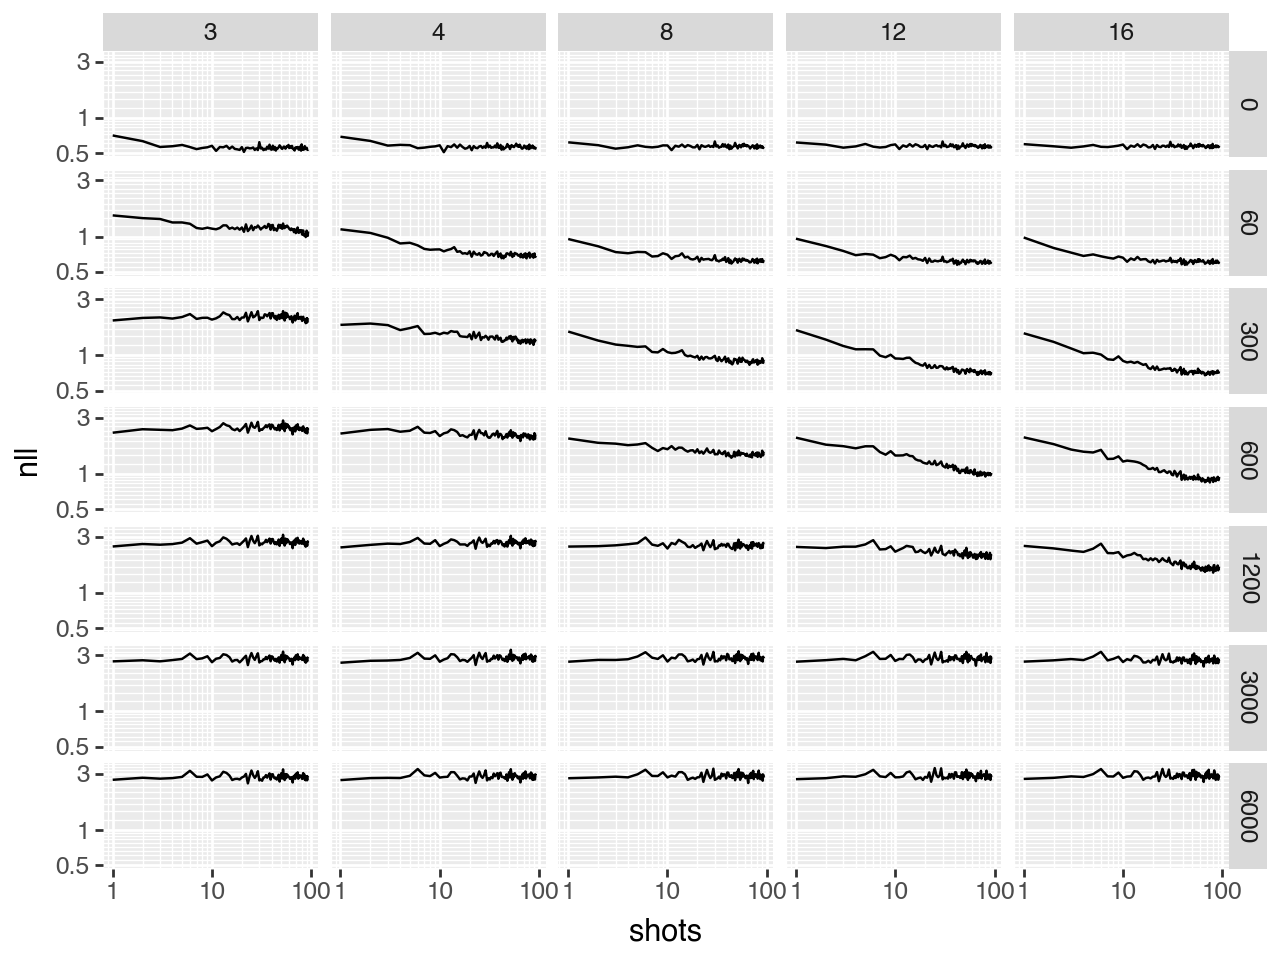

In [14]:
plot = (
    ggplot(sft_df[(sft_df["hmm"] == 1) & (sft_df["k"] == 10) & (sft_df["layers"] > 2)], aes(x="shots", y="nll")) +
    stat_summary(geom="line") + facet_grid("sft~layers") + scale_x_log10() + scale_y_log10()
)
print(plot)

In [35]:
all_params_sft = []
all_models_sft = {}
for sft_amount in sft_df["sft_amount"].unique():
    all_models_sft[sft_amount] = {}
    for k in sft_df["k"].unique():
        print(sft_amount, k)
        for layers in tqdm(sft_df["layers"].unique()):
            if layers <= 2: continue
            subset = sft_df[(sft_df["sft_amount"] == sft_amount) & (sft_df["k"] == k) & (sft_df["layers"] == layers)]
            some_params, some_models = compute_all_fits(
                subset=subset, max_shots=1.0, quiet=True, patience=100, epochs=100,
                lr=5e-2, num_hmms=5, i=0, metadata={"layers": layers, "k": k, "sft_amount": sft_amount},
                mode="lbfgs", loss_mode="mse_prob"
            )
            all_params_sft.extend(some_params)
            for key in some_models:
                if isinstance(key, tuple):
                    all_models_sft[sft_amount][(key[0], k, layers, key[1])] = some_models[key]
                else:
                    all_models_sft[sft_amount][(key, k, layers)] = some_models[key]

0 3


100%|██████████| 7/7 [00:46<00:00,  6.65s/it]


0 5


100%|██████████| 7/7 [00:36<00:00,  5.24s/it]


0 8


100%|██████████| 7/7 [00:33<00:00,  4.80s/it]


0 10


100%|██████████| 7/7 [00:29<00:00,  4.26s/it]


50 3


100%|██████████| 7/7 [00:43<00:00,  6.28s/it]


50 5


100%|██████████| 7/7 [00:20<00:00,  2.93s/it]


50 8


100%|██████████| 7/7 [00:18<00:00,  2.69s/it]


50 10


100%|██████████| 7/7 [00:19<00:00,  2.75s/it]


250 3


100%|██████████| 7/7 [00:26<00:00,  3.84s/it]


250 5


100%|██████████| 7/7 [00:23<00:00,  3.40s/it]


250 8


100%|██████████| 7/7 [00:21<00:00,  3.11s/it]


250 10


100%|██████████| 7/7 [00:18<00:00,  2.71s/it]


500 3


100%|██████████| 7/7 [00:23<00:00,  3.40s/it]


500 5


100%|██████████| 7/7 [00:26<00:00,  3.80s/it]


500 8


100%|██████████| 7/7 [00:22<00:00,  3.23s/it]


500 10


100%|██████████| 7/7 [00:22<00:00,  3.28s/it]


1000 3


100%|██████████| 7/7 [00:22<00:00,  3.20s/it]


1000 5


100%|██████████| 7/7 [00:21<00:00,  3.08s/it]


1000 8


100%|██████████| 7/7 [00:22<00:00,  3.15s/it]


1000 10


100%|██████████| 7/7 [00:24<00:00,  3.57s/it]


2500 3


100%|██████████| 7/7 [00:16<00:00,  2.30s/it]


2500 5


100%|██████████| 7/7 [00:14<00:00,  2.02s/it]


2500 8


100%|██████████| 7/7 [00:13<00:00,  1.99s/it]


2500 10


100%|██████████| 7/7 [00:14<00:00,  2.10s/it]


5000 3


100%|██████████| 7/7 [00:16<00:00,  2.38s/it]


5000 5


100%|██████████| 7/7 [00:14<00:00,  2.09s/it]


5000 8


100%|██████████| 7/7 [00:12<00:00,  1.85s/it]


5000 10


100%|██████████| 7/7 [00:13<00:00,  1.88s/it]


0.7374237706072724 3.3129296954272234


/var/folders/ks/tsqyvj_n5bv55g97m0fc7tb40000gn/T/ipykernel_70515/2457727442.py:47: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().
/Users/aryamanarora/opt/miniconda3/envs/pyvene/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10


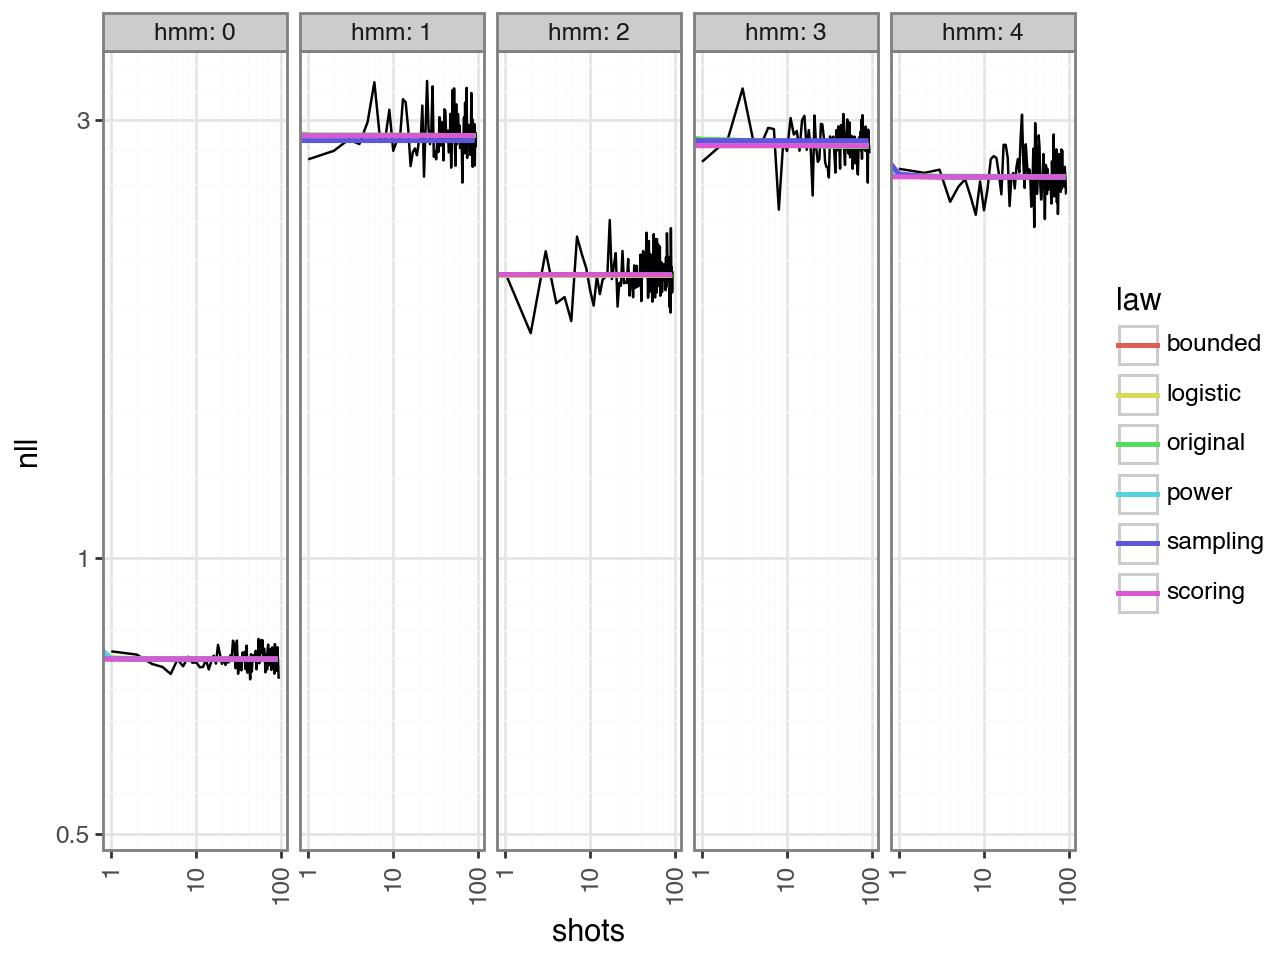

/var/folders/ks/tsqyvj_n5bv55g97m0fc7tb40000gn/T/ipykernel_70515/2457727442.py:60: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().
/Users/aryamanarora/opt/miniconda3/envs/pyvene/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10


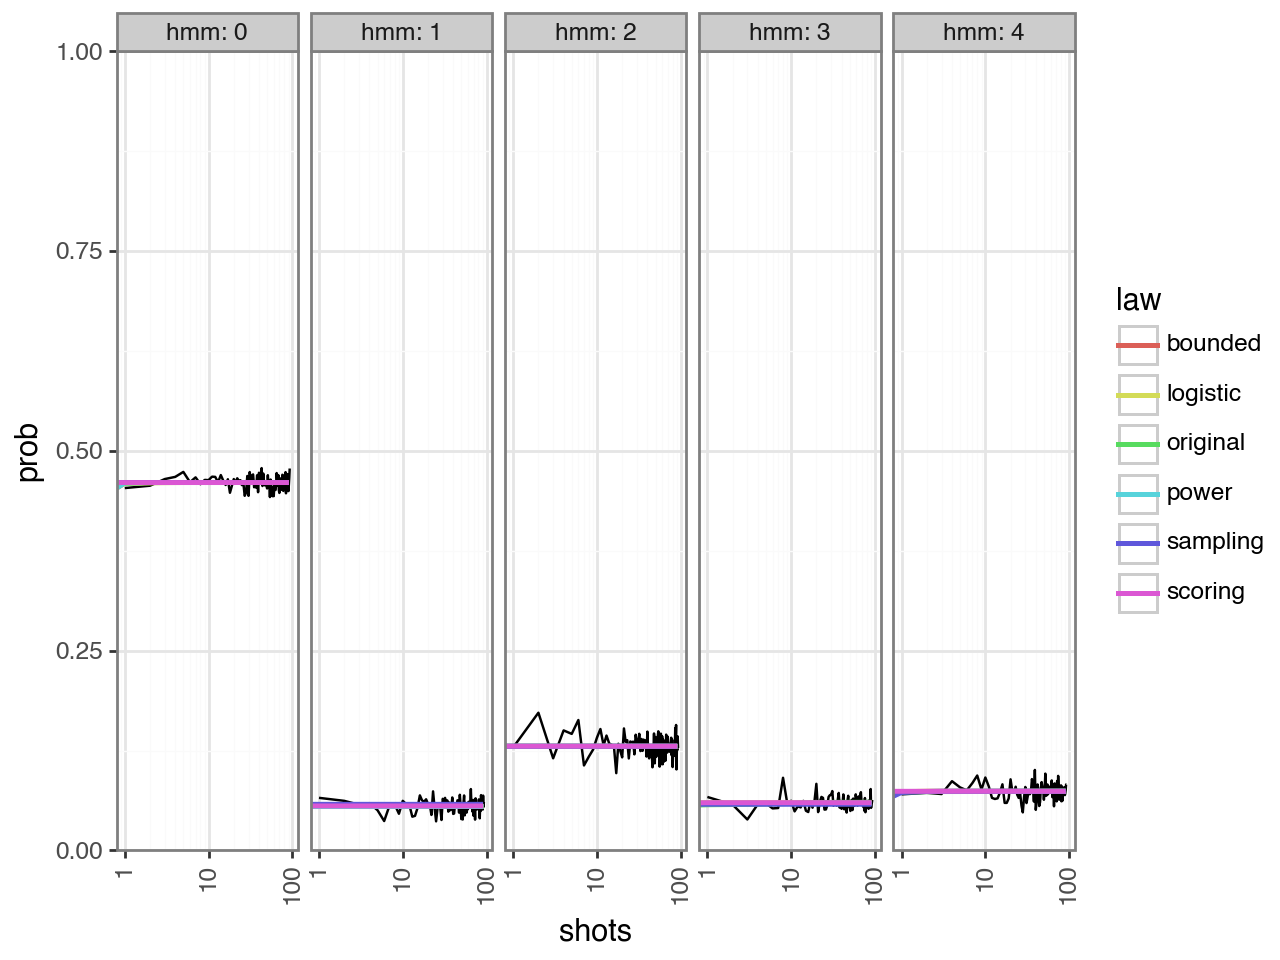

In [42]:
plot_fits(sft_df[sft_df["sft_amount"] == 5000], 10, 16, all_models_sft[5000])

In [43]:
params_sft_df = pd.DataFrame(all_params_sft)
params_sft_df.to_csv('paper/params_sft.csv', index=False)
params_sft_df['hmm'] = pd.Categorical(params_sft_df['hmm'], categories=params_sft_df['hmm'].unique(), ordered=False)
params_sft_df['k'] = params_sft_df['k'].astype(int)
params_sft_df['law'] = params_sft_df['law'].map({
    "bayesian_original": "Bayesian (O.)",
    "bayesian_sampling": "Bayesian (Sa.)",
    "bayesian_scoring": "Bayesian (Sc.)",
    "bayesian_old": "Bayesian (Old)",
    "power": "Power",
    "bounded": "Bounded",
    "logistic": "Logistic",
})
params_sft_df

,hmm,rmse,nrmse,log_rmse,log_nrmse,rmse_prob,nrmse_prob,law,priors,P,...,layers,k,sft_amount,gammas,betas,C,alpha,n_c,L,x_0
0,0,0.055306,0.042552,0.042514,0.211824,0.015049,0.055104,Bayesian (O.),3.625102e-01,"[0.0, 0.27363139390945435, 0.0, 0.273591667413...",...,3,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0.054629,0.042031,0.042158,0.209231,0.014941,0.054711,Bayesian (Sa.),1.170852e-01,NaN,...,3,3,0,0.273748,0.223031,NaN,NaN,NaN,NaN,NaN
2,0,0.054125,0.041643,0.041852,0.207299,0.014843,0.054350,Bayesian (Sc.),9.037009e-02,NaN,...,3,3,0,0.273690,0.121618,NaN,NaN,NaN,NaN,NaN
3,0,0.054490,0.041924,0.042113,0.208696,0.014933,0.054680,Power,NaN,NaN,...,3,3,0,NaN,NaN,0.424145,2.628134,NaN,NaN,NaN
4,0,0.054194,0.041697,0.041911,0.207566,0.014864,0.054429,Bounded,NaN,NaN,...,3,3,0,NaN,NaN,1.660400,15.000000,2.341763,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4195,4,0.140107,0.053615,0.053054,0.146072,0.010059,0.135931,Bayesian (Sa.),7.456393e-02,NaN,...,16,10,5000,0.074090,0.027932,NaN,NaN,NaN,NaN,NaN
4196,4,0.140105,0.053614,0.053064,0.146069,0.010065,0.136008,Bayesian (Sc.),4.094829e-08,NaN,...,16,10,5000,0.074005,0.011986,NaN,NaN,NaN,NaN,NaN
4197,4,0.140079,0.053604,0.053050,0.146042,0.010061,0.135949,Power,NaN,NaN,...,16,10,5000,NaN,NaN,0.042218,2.263655,NaN,NaN,NaN
4198,4,0.140055,0.053595,0.053039,0.146018,0.010058,0.135918,Bounded,NaN,NaN,...,16,10,5000,NaN,NaN,2.620563,5.244554,-0.077940,NaN,NaN


In [44]:
nans_by_law = params_sft_df["nrmse"].isna().groupby(params_sft_df["law"]).sum()
print(nans_by_law)

law
Bayesian (O.)     0
Bayesian (Sa.)    0
Bayesian (Sc.)    0
Bounded           0
Logistic          0
Power             0
Name: nrmse, dtype: int64


In [45]:
params_sft_df.loc[params_sft_df['sft_amount'] == 0, 'sft_amount'] += 1

In [46]:
len(params_sft_df)

4200

In [47]:
print(params_sft_df[(params_sft_df["layers"] > 2) & (params_sft_df["sft_amount"] > 1) & ~(params_sft_df["law"].str.endswith("l"))].groupby("law")["nrmse"].mean().to_latex(float_format="{:.4f}".format))
print(params_sft_df[(params_sft_df["layers"] > 2) & (params_sft_df["sft_amount"] > 1) & ~(params_sft_df["law"].str.endswith("l"))].groupby("law")["nrmse"].std().to_latex(float_format="{:.4f}".format))

\begin{tabular}{lr}
\toprule
 & nrmse \\
law &  \\
\midrule
Bayesian (O.) & 0.0415 \\
Bayesian (Sa.) & 0.0474 \\
Bayesian (Sc.) & 0.0448 \\
Bounded & 0.0420 \\
Logistic & 0.0419 \\
Power & 0.0432 \\
\bottomrule
\end{tabular}

\begin{tabular}{lr}
\toprule
 & nrmse \\
law &  \\
\midrule
Bayesian (O.) & 0.0111 \\
Bayesian (Sa.) & 0.0146 \\
Bayesian (Sc.) & 0.0117 \\
Bounded & 0.0113 \\
Logistic & 0.0112 \\
Power & 0.0113 \\
\bottomrule
\end{tabular}



In [48]:
from scipy import stats

extrap = pd.DataFrame(all_params_sft).groupby(['sft_amount', 'hmm', 'layers', 'k', 'law'])['nrmse_prob'].mean().unstack().reset_index()
extrap

print("Extrapolation test")
for law in pd.DataFrame(all_params_sft)["law"].unique():
    for law2 in pd.DataFrame(all_params_sft)["law"].unique():
        if law == law2:
            continue
        # print(law, law2)
        ttest = stats.ttest_rel(
            extrap[law],
            extrap[law2]
        )
        print(f"{'✅' if ttest.pvalue < 0.05 else '❌'} {'>' if ttest.statistic > 0 else '<'} {law:>20} vs {law2:<20}: {ttest.statistic:>8.4f}, {ttest.pvalue:>8.4f}")


Extrapolation test
✅ <    bayesian_original vs bayesian_sampling   :  -9.8554,   0.0000
✅ <    bayesian_original vs bayesian_scoring    : -12.1283,   0.0000
✅ <    bayesian_original vs power               : -10.6326,   0.0000
✅ <    bayesian_original vs bounded             :  -6.6246,   0.0000
✅ <    bayesian_original vs logistic            :  -5.9789,   0.0000
✅ >    bayesian_sampling vs bayesian_original   :   9.8554,   0.0000
✅ >    bayesian_sampling vs bayesian_scoring    :   5.7511,   0.0000
✅ >    bayesian_sampling vs power               :   8.0609,   0.0000
✅ >    bayesian_sampling vs bounded             :   9.1815,   0.0000
✅ >    bayesian_sampling vs logistic            :   9.3783,   0.0000
✅ >     bayesian_scoring vs bayesian_original   :  12.1283,   0.0000
✅ <     bayesian_scoring vs bayesian_sampling   :  -5.7511,   0.0000
✅ >     bayesian_scoring vs power               :   9.1239,   0.0000
✅ >     bayesian_scoring vs bounded             :  11.6819,   0.0000
✅ >     bayesia

/var/folders/ks/tsqyvj_n5bv55g97m0fc7tb40000gn/T/ipykernel_70515/702598186.py:6: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


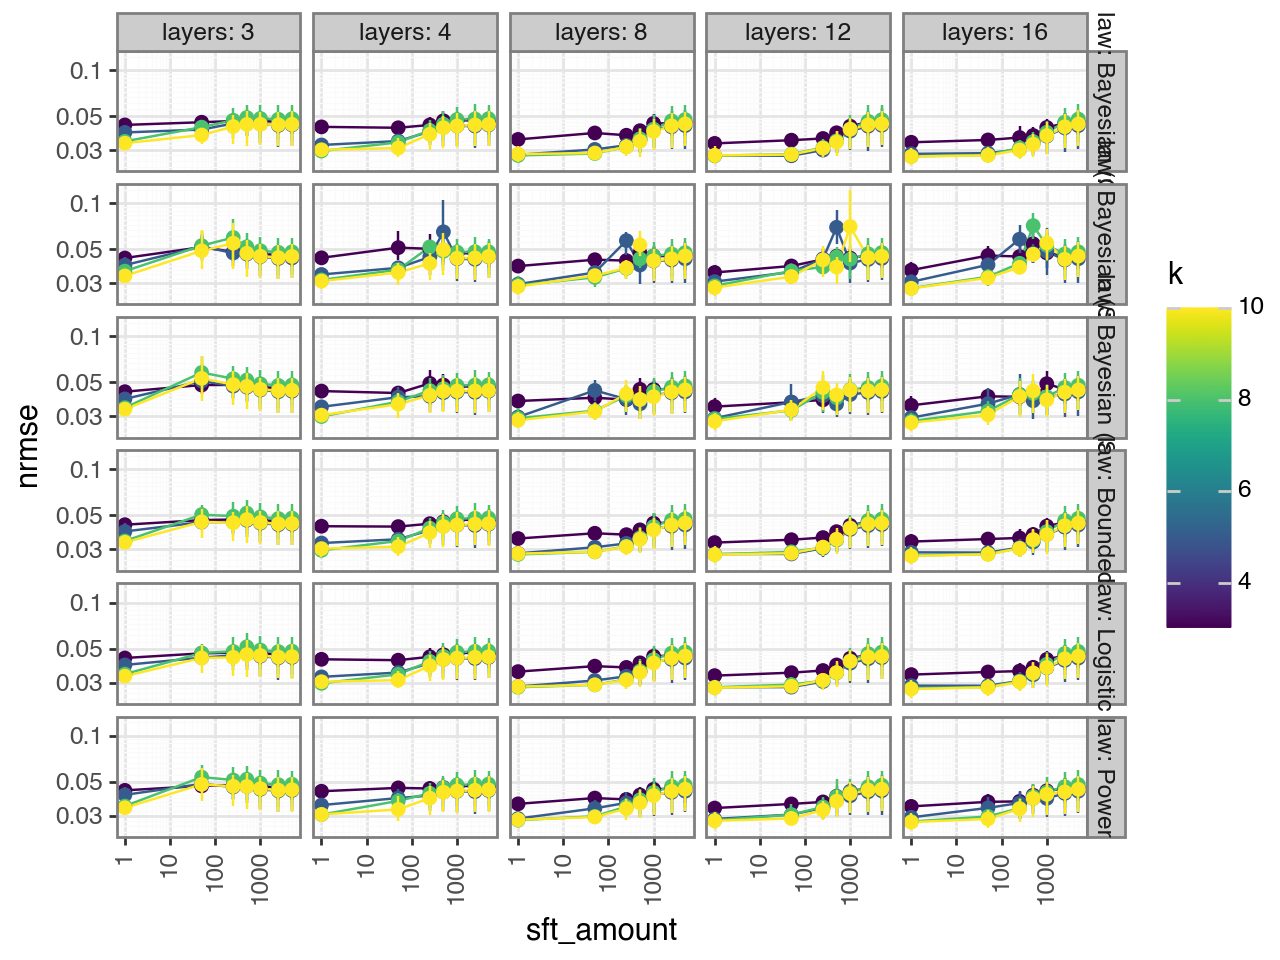

/Users/aryamanarora/opt/miniconda3/envs/pyvene/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 7 x 2.5 in image.
/Users/aryamanarora/opt/miniconda3/envs/pyvene/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: paper/law_comparison_sft.pdf


In [49]:
plot = (
    ggplot(params_sft_df, aes(x="sft_amount", y="nrmse", group="k", color="k")) +
    stat_summary(geom="line") + stat_summary() + facet_grid("law~layers", labeller="label_both") +
    theme_bw() + theme(axis_text_x=element_text(rotation=90)) + scale_x_log10() + scale_y_log10()
)
print(plot)
plot.save('paper/law_comparison_sft.pdf', width=7, height=2.5)

/var/folders/ks/tsqyvj_n5bv55g97m0fc7tb40000gn/T/ipykernel_70515/2278369671.py:8: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


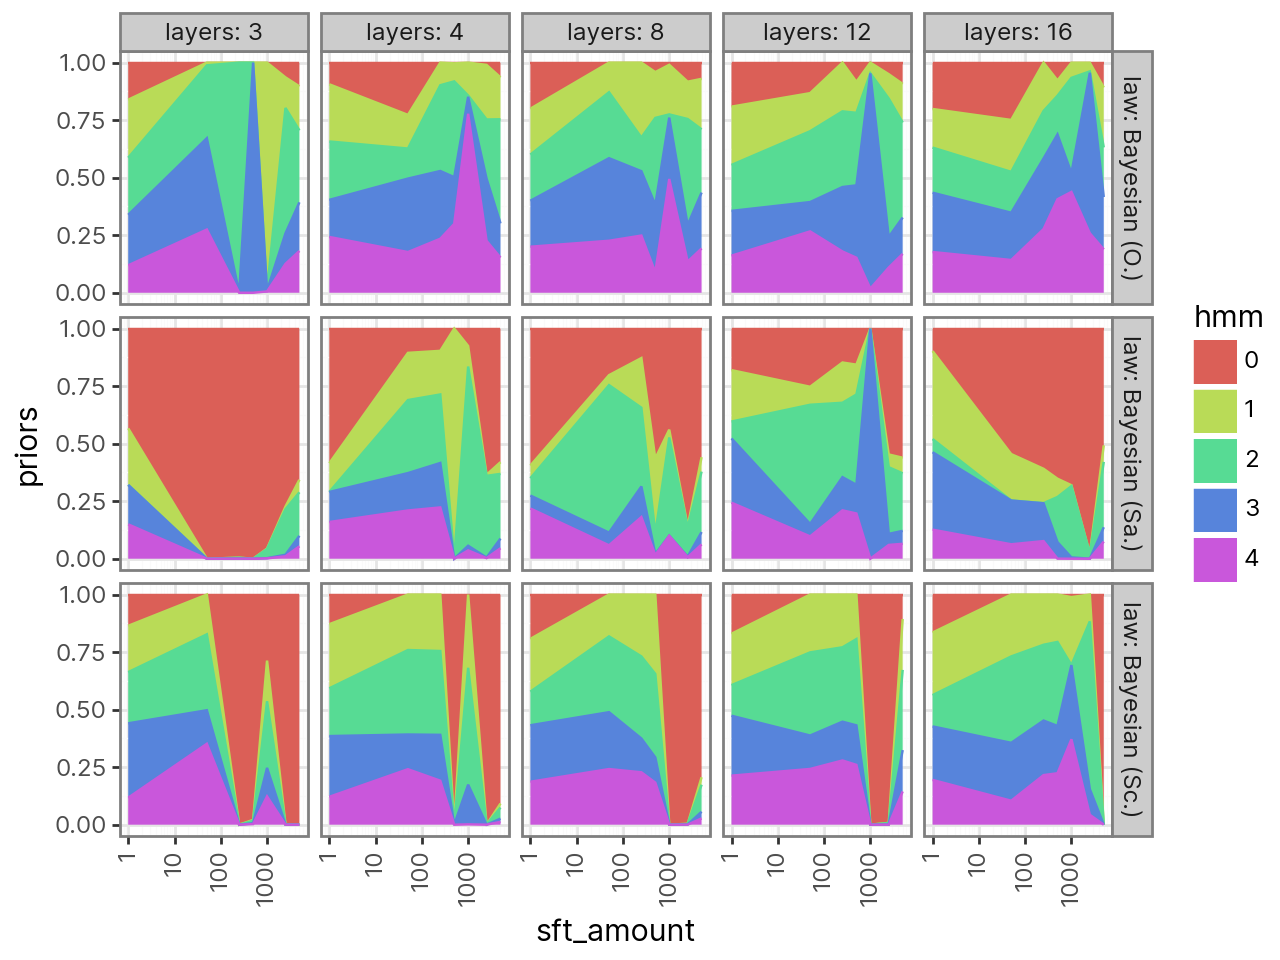

/Users/aryamanarora/opt/miniconda3/envs/pyvene/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 5 x 4 in image.
/Users/aryamanarora/opt/miniconda3/envs/pyvene/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: paper/priors_sft.pdf


In [50]:
params_sft_df_temp = params_sft_df[(params_sft_df["k"] == 10) & (params_sft_df["law"].str.startswith("Bayes"))]
plot = (
    ggplot(params_sft_df_temp, aes(x="sft_amount", y="priors", group="hmm", color="hmm", fill="hmm")) +
    # stat_summary(geom="line") + stat_summary()
    stat_summary(geom="area", position="stack") + facet_grid("law~layers", labeller="label_both") +
    theme_bw() + theme(axis_text_x=element_text(rotation=90), text=element_text(family="Inter")) + scale_x_log10()
)
print(plot)
plot.save('paper/priors_sft.pdf', width=5, height=4)

/var/folders/ks/tsqyvj_n5bv55g97m0fc7tb40000gn/T/ipykernel_70515/2895844232.py:8: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


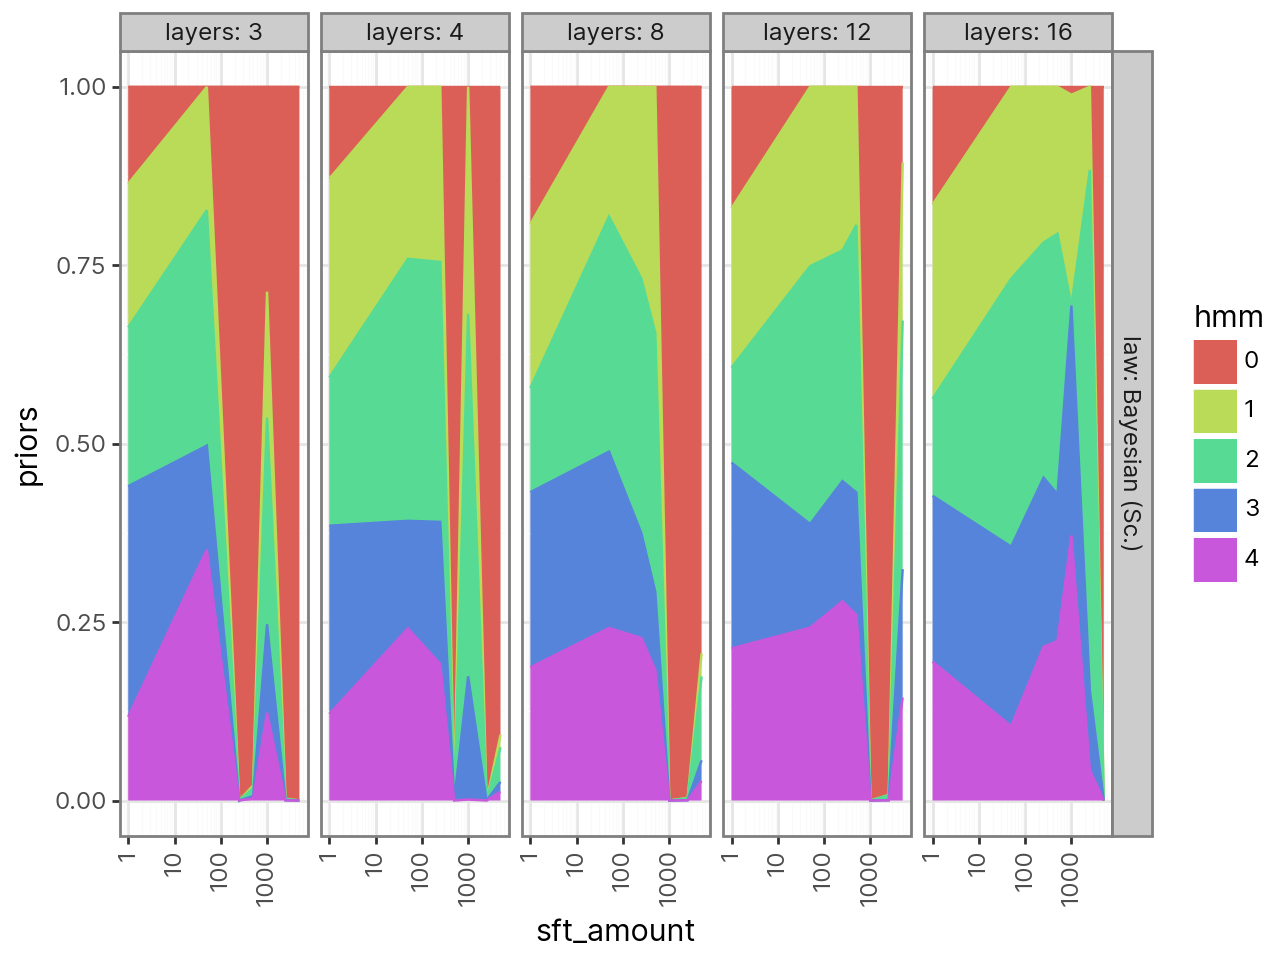

/Users/aryamanarora/opt/miniconda3/envs/pyvene/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 6 x 3 in image.
/Users/aryamanarora/opt/miniconda3/envs/pyvene/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: paper/priors_sft_only_sc.pdf


In [51]:
params_sft_df_temp = params_sft_df[(params_sft_df["k"] == 10) & (params_sft_df["law"].str.startswith("Bayesian (Sc.)"))]
plot = (
    ggplot(params_sft_df_temp, aes(x="sft_amount", y="priors", group="hmm", color="hmm", fill="hmm")) +
    # stat_summary(geom="line") + stat_summary()
    stat_summary(geom="area", position="stack") + facet_grid("law~layers", labeller="label_both") +
    theme_bw() + theme(axis_text_x=element_text(rotation=90), text=element_text(family="Inter")) + scale_x_log10()
)
print(plot)
plot.save('paper/priors_sft_only_sc.pdf', width=6, height=3)

In [ ]:
params_df_sft_temp2 = params_sft_df_temp.copy()
order = list(map(str, sorted(map(int, params_df_sft_temp2["sft_amount"].unique()))))
print(order)
params_df_sft_temp2["sft_amount"] = pd.Categorical(params_df_sft_temp2['sft_amount'].astype(str), categories=order, ordered=True)
plot = (
    ggplot(params_df_sft_temp2, aes(x="sft_amount", y="priors", group="hmm", color="hmm", fill="hmm")) +
    # stat_summary(geom="line") + stat_summary()
    stat_summary(geom="bar", position="stack") + facet_grid("law~layers", labeller="label_context") +
    theme_bw() + theme(axis_text_x=element_text(rotation=90), text=element_text(family="Inter"))
)
print(plot)
plot.save('paper/priors_sft2.pdf', width=7, height=2.5)

In [ ]:
plot = (
    ggplot(params_sft_df_temp[params_sft_df_temp["hmm"] == 0], aes(x="sft_amount", y="priors", group="layers", color="layers", fill="layers")) +
    # stat_summary(geom="line") + stat_summary()
    stat_summary(geom="line") + stat_summary() + facet_grid("law~layers", labeller="label_context") +
    theme_bw() + theme(axis_text_x=element_text(rotation=90)) + scale_x_log10()
)
print(plot)
# plot.save('paper/priors.pdf', width=5, height=2.5)

In [ ]:
plot = (
    ggplot(params_sft_df_temp, aes(x="sft_amount", y="gammas", group="layers", color="layers", fill="layers")) +
    # stat_summary(geom="line") + stat_summary()
    stat_summary(geom="line") + stat_summary() + facet_grid("law~hmm", labeller="label_context") +
    theme_bw() + theme(axis_text_x=element_text(rotation=90)) + scale_x_log10()
)
print(plot)
# plot.save('paper/gammas_sft.pdf', width=5, height=2.5)

/var/folders/ks/tsqyvj_n5bv55g97m0fc7tb40000gn/T/ipykernel_70515/1076614131.py:9: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().
/Users/aryamanarora/opt/miniconda3/envs/pyvene/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_summary : Removed 1 rows containing non-finite values.
/Users/aryamanarora/opt/miniconda3/envs/pyvene/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_summary : Removed 1 rows containing non-finite values.


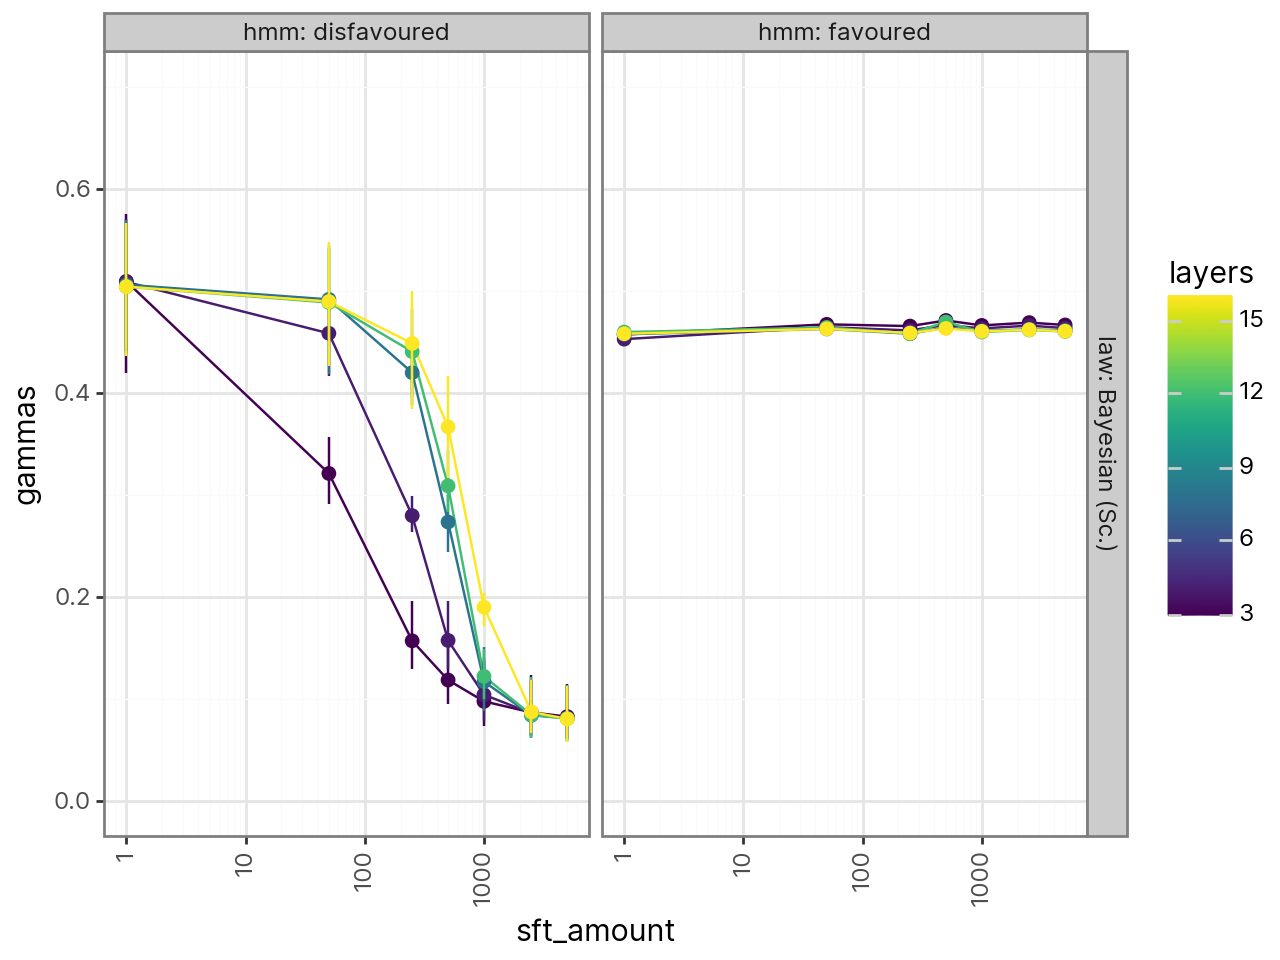

/Users/aryamanarora/opt/miniconda3/envs/pyvene/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 6 x 3 in image.
/Users/aryamanarora/opt/miniconda3/envs/pyvene/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: paper/gammas_sft.pdf
/Users/aryamanarora/opt/miniconda3/envs/pyvene/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_summary : Removed 1 rows containing non-finite values.
/Users/aryamanarora/opt/miniconda3/envs/pyvene/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_summary : Removed 1 rows containing non-finite values.


In [57]:
params_sft_df_temp2 = params_sft_df_temp.copy()
params_sft_df_temp2["hmm"] = params_sft_df_temp2["hmm"].apply(lambda x: "favoured" if x == 0 else "disfavoured")
plot = (
    ggplot(params_sft_df_temp2[params_sft_df_temp2["law"].str.startswith("Bayesian (Sc")], aes(x="sft_amount", y="gammas", group="layers", color="layers", fill="layers")) +
    # stat_summary(geom="line") + stat_summary()
    stat_summary(geom="line") + stat_summary() + facet_grid("law~hmm", labeller="label_both") +
    theme_bw() + theme(axis_text_x=element_text(rotation=90), text=element_text(family="Inter")) + scale_x_log10() + ylim(0, 0.7)
)
print(plot)
plot.save('paper/gammas_sft.pdf', width=6, height=3)

In [ ]:
plot = (
    ggplot(params_sft_df_temp, aes(x="sft_amount", y="betas", group="layers", color="layers", fill="layers")) +
    # stat_summary(geom="line") + stat_summary()
    stat_summary(geom="line") + stat_summary() + facet_grid("law~hmm", labeller="label_context") +
    theme_bw() + theme(axis_text_x=element_text(rotation=90)) + scale_x_log10()
)
print(plot)
# plot.save('paper/gammas_sft.pdf', width=5, height=2.5)

In [ ]:
plot = (
    ggplot(params_sft_df_temp[params_sft_df_temp["law"].str.startswith("Bayesian (Sc")], aes(x="sft_amount", y="betas", group="layers", color="layers", fill="layers")) +
    # stat_summary(geom="line") + stat_summary()
    stat_summary(geom="line") + stat_summary() + facet_grid("law~hmm", labeller="label_context") +
    theme_bw() + theme(axis_text_x=element_text(rotation=90)) + scale_x_log10()
)
print(plot)
plot.save('paper/betas_sft.pdf', width=7, height=3.5)

In [ ]:
plot = (
    ggplot(params_sft_df_temp, aes(x="sft_amount", y="K", group="layers", color="layers", fill="layers")) +
    # stat_summary(geom="line") + stat_summary()
    stat_summary(geom="line") + stat_summary() + facet_grid("law~layers", labeller="label_both") +
    theme_bw() + theme(axis_text_x=element_text(rotation=90)) + scale_x_log10() + scale_y_log10()
)
print(plot)
plot.save('paper/K_sft.pdf', width=7, height=2.5)

In [ ]:
pdf = params_sft_df[(params_sft_df["layers"] == 4) & (params_sft_df["k"] == 10) & (params_sft_df["law"].str.startswith("Bayesian"))]
plot = (
    ggplot(pdf, aes(x="sft_amount", y="gammas", group="hmm", color="hmm", fill="hmm")) +
    # stat_summary(geom="line") + stat_summary()
    stat_summary(geom="line") + stat_summary() + facet_grid("layers~law", labeller="label_context") +
    theme_bw() + theme(axis_text_x=element_text(rotation=90)) + scale_x_log10()
)
print(plot)

plot = (
    ggplot(pdf, aes(x="sft_amount", y="betas", group="hmm", color="hmm", fill="hmm")) +
    # stat_summary(geom="line") + stat_summary()
    stat_summary(geom="line") + stat_summary() + facet_grid("layers~law", labeller="label_context") +
    theme_bw() + theme(axis_text_x=element_text(rotation=90)) + scale_x_log10()
)
print(plot)

plot = (
    ggplot(pdf, aes(x="sft_amount", y="K", group="hmm", color="hmm", fill="hmm")) +
    # stat_summary(geom="line") + stat_summary()
    stat_summary(geom="line") + stat_summary() + facet_grid("layers~law", labeller="label_context") +
    theme_bw() + theme(axis_text_x=element_text(rotation=90)) + scale_x_log10()
)
print(plot)

## MSE

In [ ]:
data

In [ ]:
mses = []
for law in tqdm(laws):
    for k in laws[law]:
        model = laws[law][k]
        subset = data[(data['k'] == k)]
        for sft in subset['sft_amount'].unique():
            overall_mse = []
            vals = []
            for hmm in subset['hmm'].unique():
                for shots in subset['shots'].unique():
                    subsubset = subset[(subset['hmm'] == hmm) & (subset['sft_amount'] == sft) & (subset['shots'] == shots)]
                    nll = subsubset['nll'].mean()
                    pred = model(torch.tensor(shots), torch.tensor(hmm), torch.tensor(sft)).item()
                    mse = (nll - pred)**2
                    vals.append(nll)
                    overall_mse.append(mse)
            mse = sum(overall_mse) / len(overall_mse)
            rmse = mse**(0.5)
            nrmse = rmse / (sum(vals) / len(vals))
            mses.append({"k": k, "sft": sft, "mse": mse, "rmse": rmse, "nrmse": nrmse})

In [ ]:
mses2 = []
for law in tqdm(laws2):
    for (k, sft) in laws2[law]:
        model = laws2[law][(k, sft)]
        subset = data[(data['k'] == k) & (data['sft_amount'] == sft)]
        overall_mse = []
        vals = []
        for hmm in subset['hmm'].unique():
            for shots in subset['shots'].unique():
                subsubset = subset[(subset['hmm'] == hmm) & (subset['sft_amount'] == sft) & (subset['shots'] == shots)]
                nll = subsubset['nll'].mean()
                pred = model(torch.tensor(shots), torch.tensor(hmm), torch.tensor(sft)).item()
                mse = (nll - pred)**2
                vals.append(nll)
                overall_mse.append(mse)
        mse = sum(overall_mse) / len(overall_mse)
        rmse = mse**(0.5)
        nrmse = rmse / (sum(vals) / len(vals))
        mses2.append({"k": k, "sft": sft, "mse": mse, "rmse": rmse, "nrmse": nrmse})

In [ ]:
mses_all = []
for mse in mses:
    mse['law'] = 'tied'
    mses_all.append(mse)
for mse in mses2:
    mse['law'] = 'untied'
    mses_all.append(mse)

In [ ]:
mse_df = pd.DataFrame(mses_all)
print(mse_df)
plot = (
    ggplot(mse_df, aes(x="sft", y="nrmse", color="law")) + stat_summary() +
    stat_summary(geom="line") + facet_grid("~k") + theme(axis_text_x=element_text(rotation=90)) +
    scale_x_log10()
)
print(plot)

In [ ]:
mse_df = pd.DataFrame(mses_all)
print(mse_df)
plot = (
    ggplot(mse_df, aes(x="sft", y="rmse", color="law")) + stat_summary() +
    stat_summary(geom="line") + facet_grid("~k") + theme(axis_text_x=element_text(rotation=90)) +
    scale_x_log10()
)
print(plot)

## Checking a single ICL curve

In [ ]:
data = pd.read_csv(f"logs/4-1,1,1,1,1-1,0,0,0,0/in_context_probs.csv")
print(data["sft"].unique())
print(data["sft_amount"].unique())
data

In [ ]:
filter = (data['sft_amount'] == -1)
for sft_amount in data['sft_amount'].unique():
    maxi = data[data['sft_amount'] == sft_amount]['sft'].max()
    filter |= ((data['sft'] == maxi) & (data['sft_amount'] == sft_amount)) 
data = data[filter]

In [ ]:
plot = (
    ggplot(data, aes(x="shots", y="nll", color="sft_amount")) + geom_point() +
    facet_grid("k~hmm")
)
print(plot)

In [ ]:
plot = (
    ggplot(data[data["sft"] == 1], aes(x="shots", y="prob", color="sft_amount")) + geom_point() +
    facet_grid("k~hmm")
)
print(plot)

In [ ]:
plot = (
    ggplot(data, aes(x="shots", y="nll", color="sft_amount")) + geom_point() +
    facet_grid("k~hmm")
)
print(plot)

## MSE analysis

In [ ]:
dfs = []
pretrain: str="1,1,1,1,1"
sft: str="1,0,0,0,0"
layers: str="1,2,3,4,8,12,16"
for layer in layers.split(","):
    # set up dir
    directory = f"figs/{pretrain}-{sft}/"
    if os.path.exists(f"{directory}/all_law_params-{layer}-sft.csv"):
        # load data
        data = pd.read_csv(f"{directory}/all_law_params-{layer}-sft.csv")
        data['layers'] = int(layer)
        dfs.append(data)
    else:
        print(f"File {directory}/all_law_params-{layer}-sft.csv does not exist")

# format df
df_all = pd.concat(dfs)
order = list(map(str, sorted(df_all['layers'].unique())))
df_all['layers'] = pd.Categorical(df_all['layers'].astype(str), categories=order, ordered=True)

# drop sft_amount == "none"
df_all = df_all[df_all['sft_amount'] != "none"]
df_all['sft_amount'] = df_all['sft_amount'].astype(float)

In [ ]:
df_all

In [ ]:
plot = (
    ggplot(df_all[(df_all["k"] == 10)], aes(x='sft_amount', y='mse', color='law')) +
    geom_line() + theme(axis_text_x=element_text(rotation=90)) +
    facet_grid("layers~hmm") + scale_x_log10() + scale_y_log10()
)
print(plot)

In [ ]:
plot = (
    ggplot(df_all[(df_all["k"] == 10)], aes(x='sft_amount', y='nrmse', color='law')) +
    geom_line() + theme(axis_text_x=element_text(rotation=90)) +
    facet_grid("layers~hmm") + scale_x_log10() + scale_y_log10()
)
print(plot)

In [ ]:
df_all = df_all[df_all['law'] == 'bayesian']
df_all

In [ ]:
# df = pd.melt(df_all, id_vars=['sft_amount', 'k', 'hmm', 'layers'], value_vars=['gammas', 'betas'], var_name='metric', value_name='value')
from copy import deepcopy

df = deepcopy(df_all)
df['diff'] = df['gammas'] - df['betas']
df

In [ ]:
plot = (
    ggplot(df, aes(x='sft_amount', y='diff', color='layers')) + geom_point() +
    geom_line() + scale_x_log10() + theme(axis_text_x=element_text(rotation=90)) +
    facet_grid("k~hmm", labeller="label_both")
)
print(plot)

In [ ]:
plot = (
    ggplot(df, aes(x='sft_amount', y='priors', color='layers')) +
    geom_line() + scale_x_log10() + theme(axis_text_x=element_text(rotation=90)) +
    scale_y_log10() +
    facet_grid("k~hmm", labeller="label_both")
)
print(plot)

In [ ]:
import math

def inv_sigmoid(x):
    return -math.log((1-x)/x)

In [ ]:
df['gammas_s'] = df.apply(lambda x: inv_sigmoid(x['gammas']), axis=1)
df

In [ ]:
plot = (
    ggplot(df[(df["layers"] == '16') & (df["k"] == 10)], aes(x='sft_amount', y='mse', color='layers')) +
    geom_line() + theme(axis_text_x=element_text(rotation=90)) +
    facet_grid("k~hmm", labeller="label_both") + scale_x_log10()
)
print(plot)